# 🎃 Open Data Science Competition Hosted By NVIDIA 🎃

Note: Make sure to use A100 GPU to run the notebook

## 📜 Problem Statement
Hidden within our mysterious dataset are the details of **12 million monsters** from around the world. Each ghastly ghoul and sinister spirit is described by **106 monstrous anonymous features** — some categorical, some numerical, all horrifyingly fascinating. From *fang length* and *howls-per-minute* to *favorite haunt* and *cape swirl radius*, each feature holds clues that could help you crack this Halloween mystery!

### 🕵️ The Challenge
The ultimate question remains: **Who is the Scariest Monster of them all?** 🏆💀  
Your task is to build a regression model to predict the target variable, **"y"** — the number of votes each monster received in the global terror poll.  

**Requirements:**  
- Use NVIDIA RAPIDS api to boost processing on GPU

## 📊 Evaluation Criteria
Your submissions will be evaluated using the **Root Mean Squared Error (RMSE)** metric, where lower scores indicate better model performance.  

- **Leaderboard**: The final ranking for the **Top 10** will be based on the private leaderboard, which evaluates submissions on a hidden subset of the test data.

---

### ⚙️ Notebook Outline
1. **Data Loading & Exploration**  
2. **Preprocessing**  
3. **Modeling**  
4. **Evaluation & Submission**

---

**Let's dive in and discover the scariest monster among them all! 👻**

---


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paragdeshpande0","key":"10ac22f6fa79a204640bc2e1db343cd7"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c odsc-2024-nvidia-hackathon


100% 3.72G/3.72G [02:47<00:00, 24.2MB/s]
100% 3.72G/3.72G [02:47<00:00, 23.9MB/s]


In [ ]:
!unzip odsc-2024-nvidia-hackathon.zip


Archive:  odsc-2024-nvidia-hackathon.zip
  inflating: sample-submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install cuml-cu12==24.10.*

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requ

### Importing required libraries

In [ ]:
import cudf
import numpy as np
import pandas as pd
import cuml
from cuml.metrics import mean_squared_error
from cuml.model_selection import train_test_split
import cuml.neighbors
import cupy as cp
from cuml.ensemble import RandomForestRegressor


In [ ]:
df = cudf.read_csv('train.csv', index_col='id')


In [ ]:
df.info(1)

<class 'cudf.core.dataframe.DataFrame'>
Index: 11000000 entries, 0 to 10999999
Data columns (total 107 columns):
 #   Column            Dtype
---  ------            -----
 0   y                 float64
 1   trickortreat      object
 2   kingofhalloween   object
 3   mumming           float64
 4   noon              float64
 5   costumes          float64
 6   celebrate         int64
 7   confectionary     float64
 8   predestinated     int64
 9   leprechaun        float64
 10  headless          float64
 11  jacksantino       float64
 12  mystical          float64
 13  folklore          int64
 14  tarantula         int64
 15  paranormal        float64
 16  northernlights    int64
 17  quirky            float64
 18  venom             int64
 19  ectoplasm         int64
 20  jester            int64
 21  nightmare         int64
 22  isolation         int64
 23  cobwebs           float64
 24  purim             int64
 25  sweets            int64
 26  duskhour          float64
 27  bedford      

In [ ]:
df.describe()

,y,mumming,noon,costumes,celebrate,confectionary,predestinated,leprechaun,headless,jacksantino,...,interday,occult,fogmachine,holi,churchyard,satan,monsterhunter,tabulatable,vampire,hallo
count,1.100000e+07,9.945438e+06,1.063272e+07,1.007027e+07,1.100000e+07,1.088098e+07,1.100000e+07,1.092793e+07,1.053652e+07,1.041555e+07,...,1.100000e+07,1.100000e+07,1.100000e+07,1.028230e+07,1.100000e+07,1.100000e+07,1.059973e+07,1.052064e+07,1.100000e+07,1.053156e+07
mean,4.234793e+04,-2.630000e-04,4.999363e+00,4.999849e+00,1.781785e+04,-5.460000e-04,2.615036e+04,4.999430e-01,5.000010e-01,4.910000e-04,...,3.055751e+04,2.542691e+04,4.450736e+04,5.000220e-01,2.128686e+04,2.217788e+04,4.999745e+00,-5.100000e-05,9.450171e+03,-1.883000e-03
std,6.671705e+02,1.000007e+00,2.886870e+00,2.886740e+00,1.232148e+04,9.993770e-01,1.637128e+04,2.886010e-01,2.886470e-01,9.998540e-01,...,1.793895e+04,1.724091e+04,3.052474e+04,2.887510e-01,1.402527e+04,1.358391e+04,2.886795e+00,9.997660e-01,6.453440e+03,2.606650e-01
min,0.000000e+00,-5.451599e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-5.757450e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-5.277115e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-4.921169e+00,-1.000000e+00,-4.960940e-01
25%,4.190457e+04,-6.746250e-01,2.499305e+00,2.500232e+00,6.660000e+03,-6.744140e-01,1.185100e+04,2.500420e-01,2.501330e-01,-6.742150e-01,...,1.501800e+04,9.959000e+03,1.697200e+04,2.497940e-01,8.854000e+03,1.036000e+04,2.499841e+00,-6.746380e-01,3.640000e+03,-2.187500e-01
50%,4.234498e+04,-3.000000e-04,4.998342e+00,4.999110e+00,1.760700e+04,-4.890000e-04,2.610600e+04,4.998880e-01,4.999820e-01,5.650000e-04,...,3.055600e+04,2.519700e+04,4.404300e+04,5.000550e-01,2.116700e+04,2.215900e+04,4.999119e+00,-1.110000e-04,9.355000e+03,0.000000e+00
75%,4.278975e+04,6.738290e-01,7.499453e+00,7.499727e+00,2.855700e+04,6.741040e-01,4.035300e+04,7.498120e-01,7.499360e-01,6.749700e-01,...,4.608500e+04,4.043200e+04,7.109800e+04,7.501500e-01,3.348000e+04,3.394900e+04,7.500125e+00,6.744090e-01,1.507400e+04,2.109380e-01
max,5.016323e+04,5.356245e+00,1.000000e+01,1.000000e+01,3.950500e+04,5.472021e+00,5.459200e+04,1.000000e+00,1.000000e+00,5.236777e+00,...,6.163400e+04,5.567300e+04,9.816400e+04,1.000000e+00,4.579700e+04,4.574800e+04,1.000000e+01,5.739811e+00,2.078300e+04,5.000000e-01


In [ ]:
df.isnull().sum()

y                        0
trickortreat        976662
kingofhalloween    1026793
mumming            1054562
noon                367275
                    ...   
satan                    0
monsterhunter       400267
tabulatable         479359
vampire                  0
hallo               468437
Length: 107, dtype: int64

### Getting count of coulmns which have missing entries


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()

# Filter columns that have missing values
missing_features = missing_values[missing_values > 0]
missing_features.count()

53

### Getting count of numerical columns which have missing entries

In [ ]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
missing_count = sum(df[col].isnull().any() for col in numerical_cols)
missing_count

51

### Dropping categorical columns as it results in sparse matrix if we perform one hot encoding or label encoding

- Note: Due to time constraints for the ODSC competition we have not looked at other methods to process categorical values, although some methods such as sentence transformers can be used to obtain word embeddings which could help the model with better predictions

In [ ]:
df = df.drop(columns=['trickortreat', 'kingofhalloween'], axis=1)


### Performing mean imputation for all numerical columns

In [ ]:
for col in numerical_cols:
    if df[col].isnull().any():  # Check if the column has missing values
        mean_value = df[col].mean()  # Calculate mean
        df[col].fillna(mean_value, inplace=True)

In [ ]:
df.isna().sum().sum()

0

### Outlier removal and robust normalization is used




In [ ]:
for col in numerical_cols:
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1  # Interquartile range
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr

  df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]



median_values = {}
iqr_values = {}

for col in numerical_cols:
    median = df[col].median()
    q1 = df[col].quantile(0.25)  # 1st quartile
    q3 = df[col].quantile(0.75)  # 3rd quartile
    iqr = q3 - q1
    median_values[col] = median
    iqr_values[col] = iqr
    df[col] = (df[col] - median) / iqr

def inverse_robust_scale(scaled_value, median, iqr):
    return (scaled_value * iqr) + median



In [ ]:
df.head()

,y,mumming,noon,costumes,celebrate,confectionary,predestinated,leprechaun,headless,jacksantino,...,interday,occult,fogmachine,holi,churchyard,satan,monsterhunter,tabulatable,vampire,hallo
id,,,,,,,,,,,,,,,,,,,,,
0,-0.729990,0.767472,-0.067800,-0.072239,-0.198822,1.487690,0.261034,0.133484,-0.721197,1.180887,...,0.498487,0.744668,0.099616,0.890408,-0.308005,-0.547594,-0.068108,0.241520,-0.134662,1.083160
1,0.117216,-0.503142,-0.704664,-0.749797,0.361332,0.434839,0.926812,0.750811,-0.352172,-0.036543,...,0.042710,-0.387478,-0.053854,0.249693,0.131300,0.254102,-0.707122,0.729541,0.388947,0.191002
2,-0.526312,0.000000,0.234266,0.249128,0.906230,0.887218,0.511438,0.585175,0.752617,-0.151019,...,0.418313,0.581348,0.742407,0.268255,-0.859684,0.509900,0.234977,0.288850,-0.265565,-1.112921
3,0.538810,0.359307,1.026951,1.092463,0.322006,0.319613,0.066346,0.353284,-0.561020,-1.153256,...,0.908915,-0.657807,0.000000,0.490127,-0.213662,0.593725,1.030338,-0.180603,-0.034977,-0.701157
4,-0.588681,0.390598,-0.568482,-0.604913,0.488490,-0.215814,-0.206442,0.061179,0.210129,0.000000,...,-0.166624,0.700597,0.537855,-0.054322,-0.728790,-0.256265,-0.570480,-0.085812,0.773522,-1.142333


### Handling memory during train test split
- Here we did not use train test split funciton from sklearn as it was taking up a lot of memory in the GPU. To solve this problem we created a random shuffled column which has number of rows equal to the dataframe. We joined this column to the main dataframe and sorted it. But doing this we are able to shuffle the dataset and split them by performing slicing operations. Once this is done we have dropped the random column as it is no longer required

In [ ]:
Y = df['y']
df = df.drop(columns=['y'], axis=1)

n_samples = len(df)
n_test = int(0.2 * n_samples)


random_series = cudf.Series(cp.random.rand(n_samples))


df['random'] = random_series


X_sorted = df.sort_values('random').reset_index(drop=True)


X_sorted = X_sorted.drop('random', axis=1)

y_sorted = Y.loc[df.sort_values('random').index].reset_index(drop=True)

X_train = X_sorted.iloc[n_test:]
X_test = X_sorted.iloc[:n_test]
y_train = y_sorted.iloc[n_test:]
y_test = y_sorted.iloc[:n_test]

In [ ]:
n_estimators = 200
max_depth = 15

model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features='auto', random_state=42)
model.fit(X_train, y_train)

y_pred_normalized = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: FutureWarning: `max_features='auto'` has been deprecated in 24.06 and will be removed in 25.08. To keep the past behaviour and silence this warning, explicitly set `max_features=1.0`.
  ret = func(*args, **kwargs)


### Inverse robust scaling on obatin RMSE value

In [ ]:
def inverse_robust_scale(scaled_value, median, iqr):
    return (scaled_value * iqr) + median

y_pred = inverse_robust_scale(y_pred_normalized, median_values['y'], iqr_values['y'])

y_test_original = inverse_robust_scale(y_test.values, median_values['y'], iqr_values['y'])

rmse = cp.sqrt(mean_squared_error(y_test_original, y_pred)).get()
print(f"RMSE: {rmse}")

median_y = median_values['y']
iqr_y = iqr_values['y']


RMSE: 617.8202873762307


## Performing predictions on test data

In [ ]:
df = cudf.read_csv("test.csv", index_col="id")
df = df.drop(['trickortreat', 'kingofhalloween','y'], axis=1)

Mean Imputation

In [ ]:
for col in numerical_cols:
    if col=='y':
      continue
    if df[col].isnull().any():
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)

Outlier detection and robust normalization

In [ ]:
for col in numerical_cols:
  if col=='y':
    continue
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr


median_values = {}
iqr_values = {}

for col in numerical_cols:
    if col=='y':
      continue
    median = df[col].median()
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    median_values[col] = median
    iqr_values[col] = iqr
    df[col] = (df[col] - median) / iqr


def inverse_robust_scale(scaled_value, median, iqr):
    return (scaled_value * iqr) + median

In [ ]:
X = df.copy()

In [ ]:
len(df)

1000000

In [ ]:
final_preds=model.predict(X)

Here we are making an assumption that the medain and iqr is the same for train data and test data. This is often not a good practice while testing model on test data


In [ ]:
# Step 7: Inverse transform the predicted values and actual target values
def inverse_robust_scale(scaled_value, median, iqr):
    return (scaled_value * iqr) + median

# Inverse transform predictions and actual values
y_pred = inverse_robust_scale(final_preds, median_y, iqr_y)

In [ ]:
y_pred

id
12000000    42219.537830
12000001    42425.053247
12000002    42399.425116
12000003    42410.755818
12000004    42425.086957
                ...     
12999995    42460.019648
12999996    42407.806313
12999997    42159.122077
12999998    42381.695836
12999999    42384.695773
Length: 1000000, dtype: float64

In [ ]:
y_pred = y_pred.to_cupy()

In [ ]:
ids =df.index.to_cupy()

In [ ]:
sub = cudf.DataFrame({'id': ids, 'y': y_pred})
sub.to_csv('submission.csv', index=False)

In [ ]:
sub.head()

,id,y
0,12000000,42219.537830
1,12000001,42425.053247
2,12000002,42399.425116
3,12000003,42410.755818
4,12000004,42425.086957


## Submission scores we got after submitting our solution to the competition

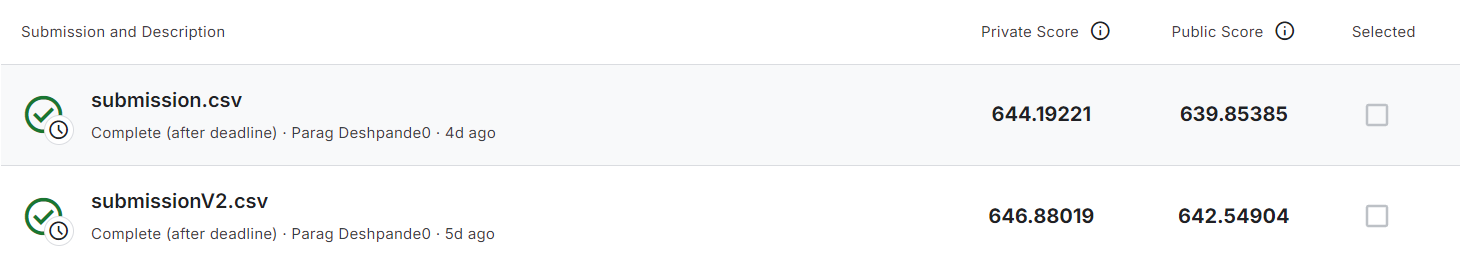

In [2]:
from IPython.display import Image, display
display(Image('/content/sub.png'))


## Leaderboard of top 5 peforming teams

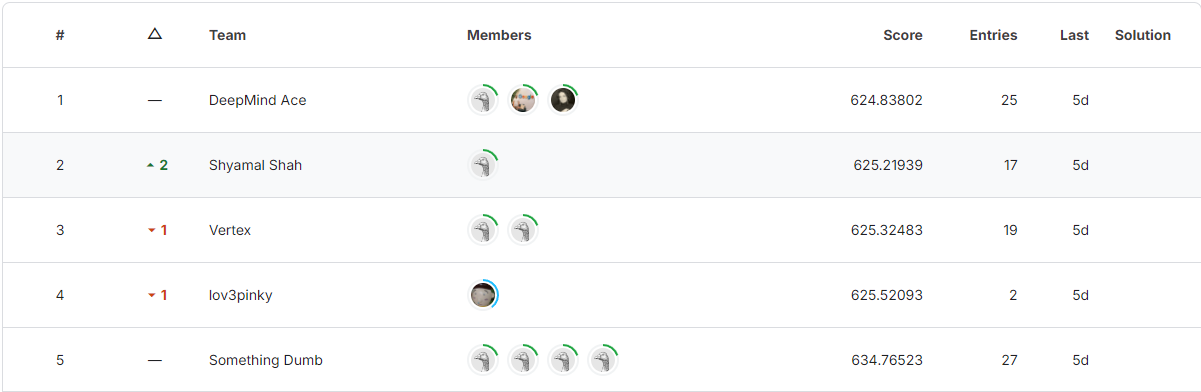

In [4]:
display(Image('/content/leaderboard.png'))